Processing Random Forest for patient 1
best n:400
best depth:13


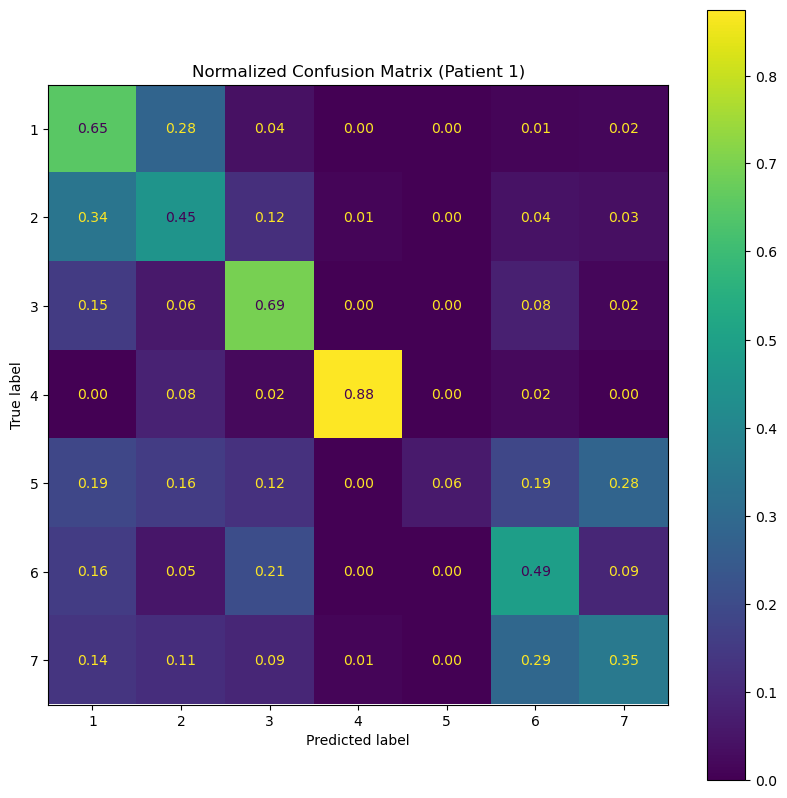

Processing Random Forest for patient 2
best n:175
best depth:27


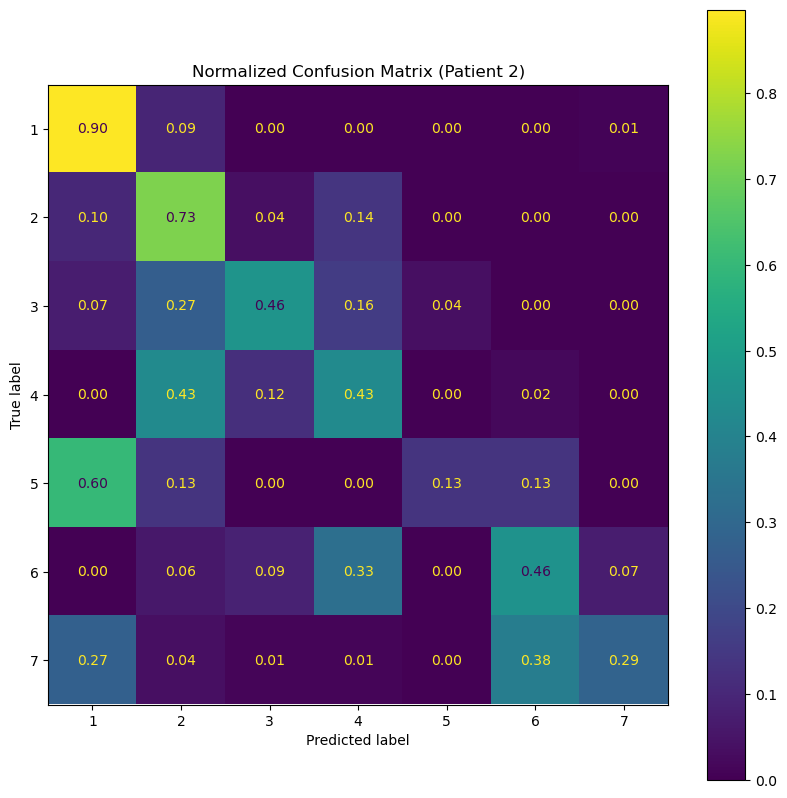

Processing Random Forest for patient 3
best n:375
best depth:15


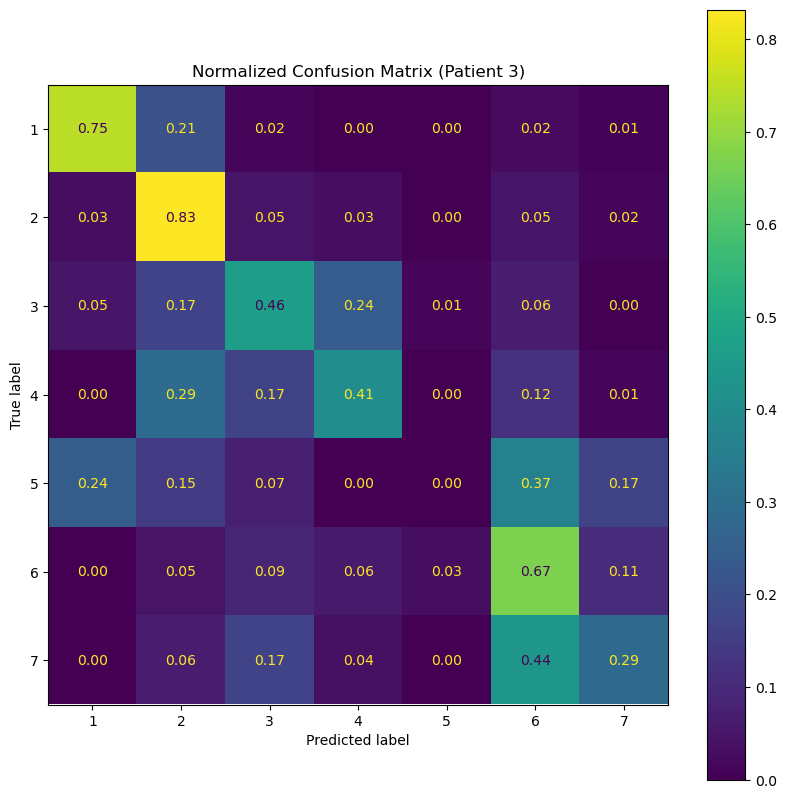

Processing Random Forest for patient 4
best n:450
best depth:31


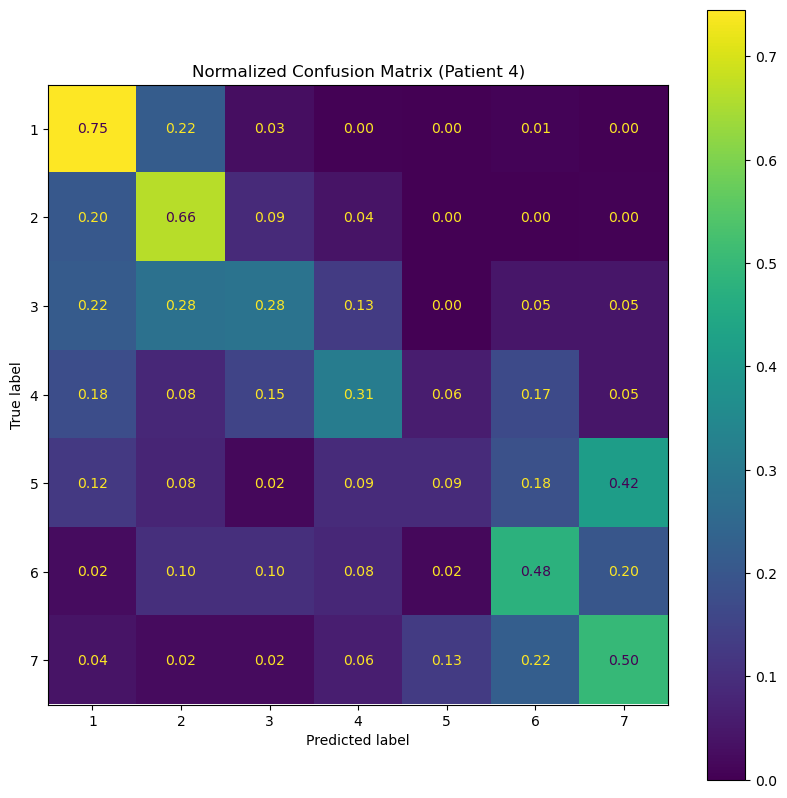

Processing Random Forest for patient 5
best n:100
best depth:14


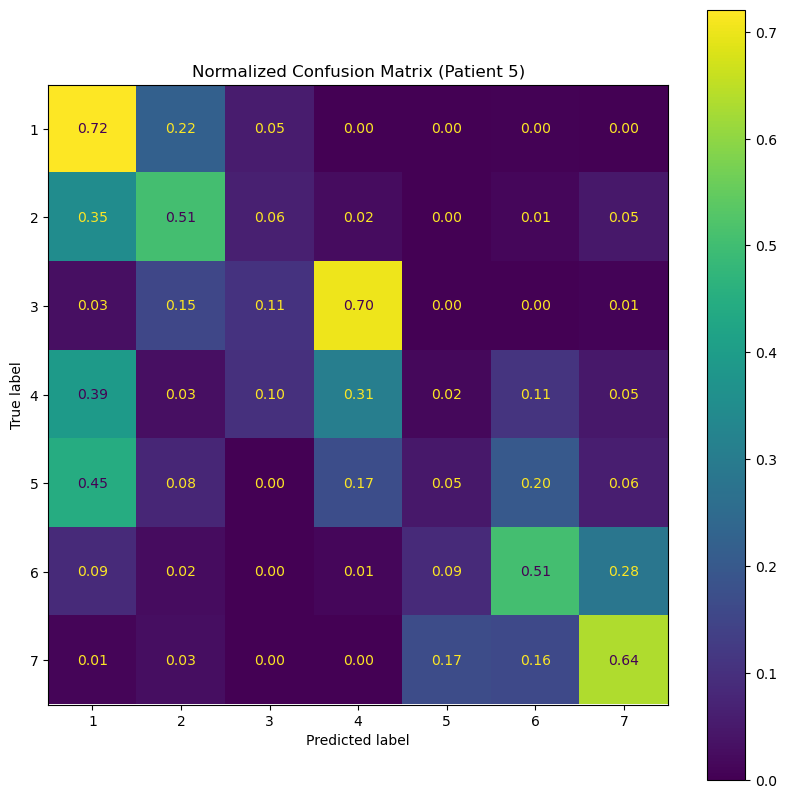

Processing Random Forest for patient 6
best n:425
best depth:27


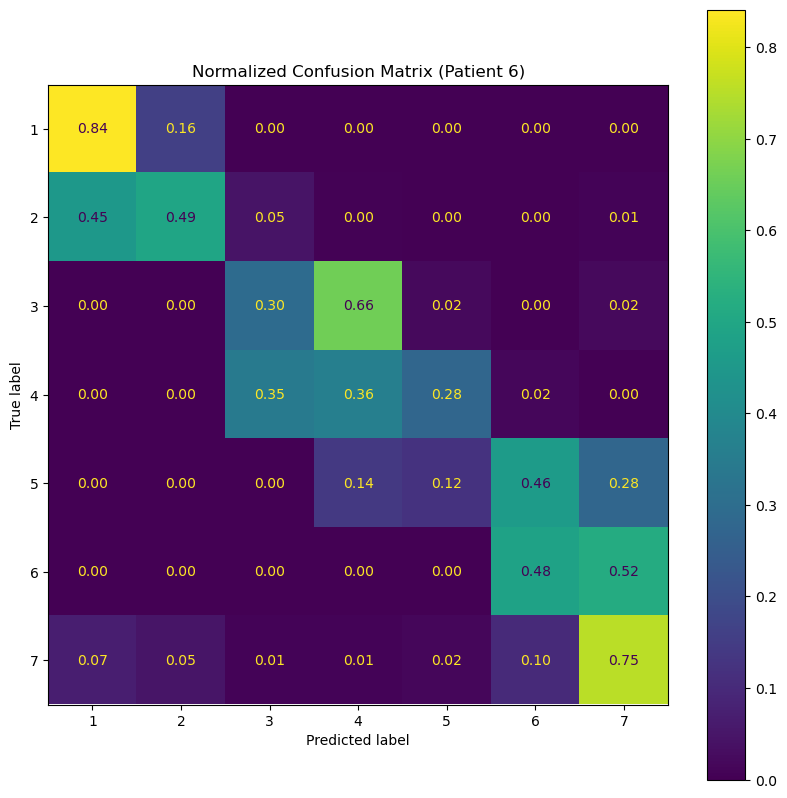

Processing Random Forest for patient 7
best n:475
best depth:20


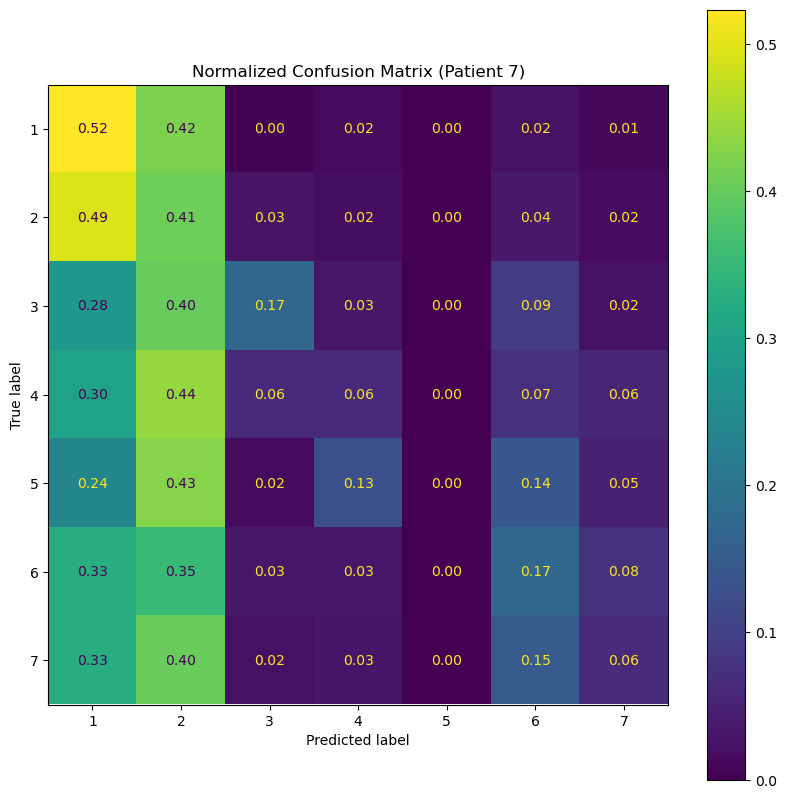

Processing Random Forest for patient 8
best n:150
best depth:27


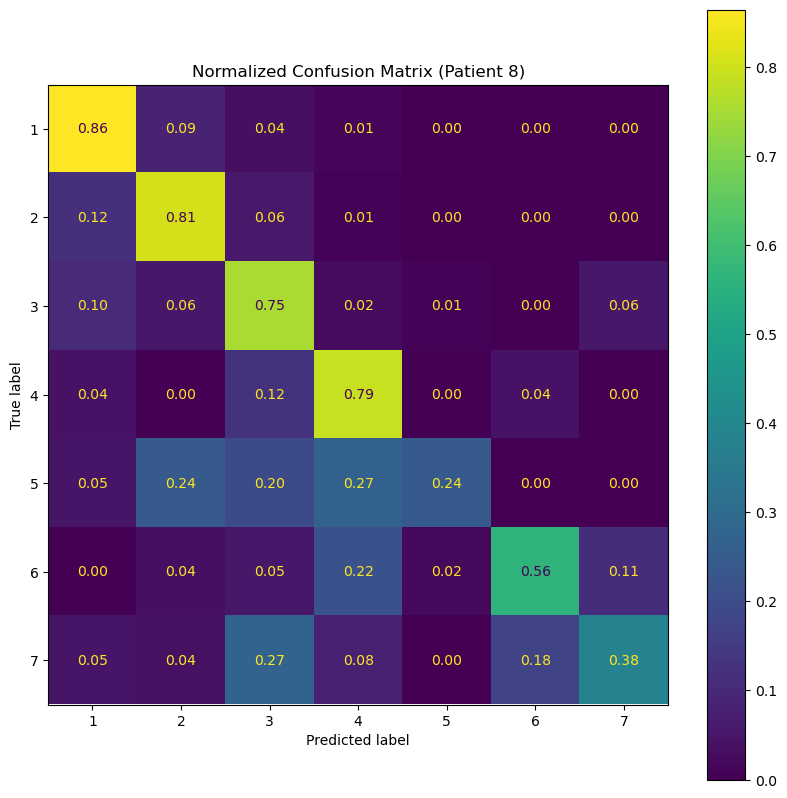

Processing Random Forest for patient 9
best n:150
best depth:16


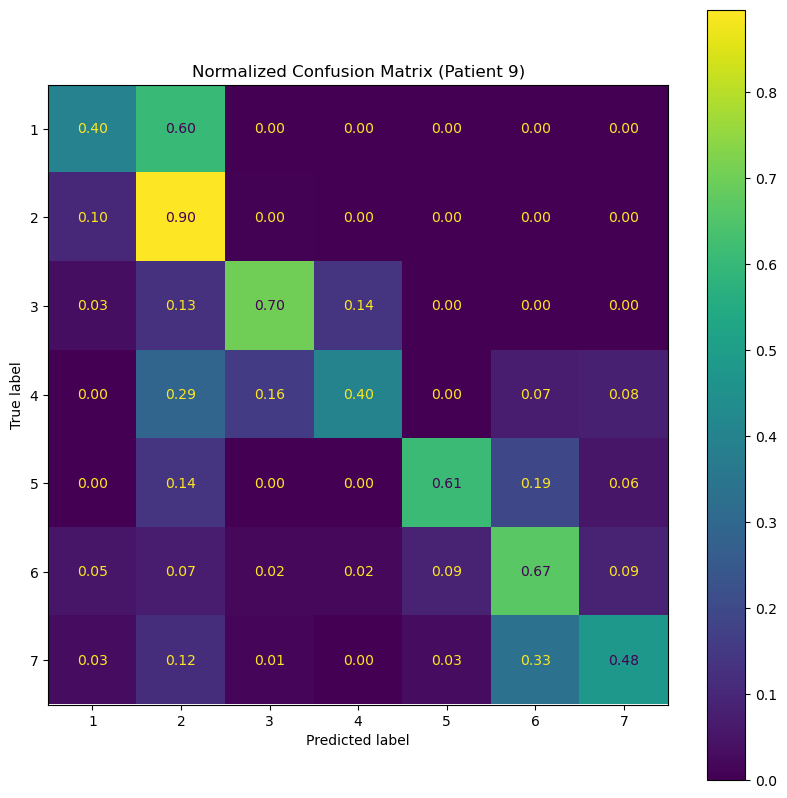

Processing Random Forest for patient 10
best n:425
best depth:25


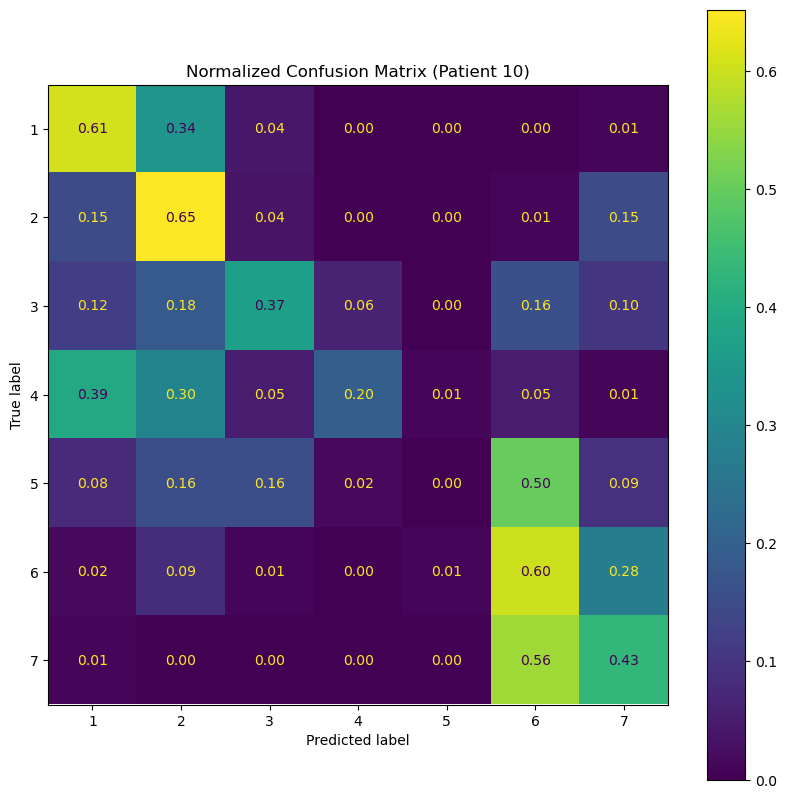

Processing Random Forest for patient 11
best n:150
best depth:21


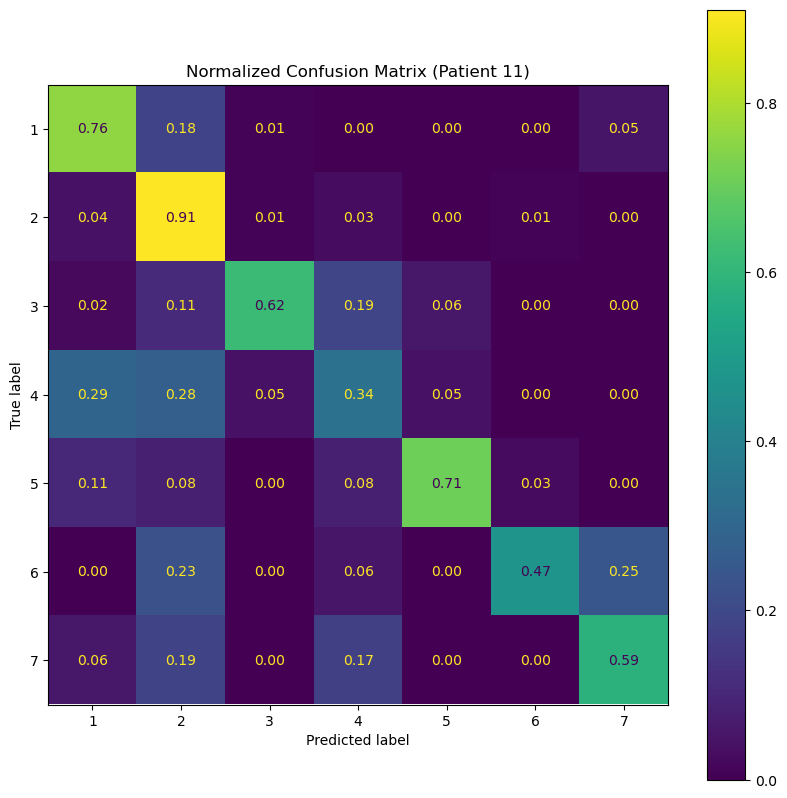

File not found for patient 12: /Users/aidantang/Desktop/Gesture_recog/Feature_extract_dataV2/S12_features_regrouped.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import os
import plotly.graph_objects as go
from scipy.interpolate import griddata
import scipy.stats as stats
import statsmodels.api as sm

# Data folder
data_folder = '/Users/aidantang/Desktop/Gesture_recog/Feature_extract_dataV2'

# Store results for plotting
results = []

# List of patient IDs
patient_ids = range(1, 13)

# Iterate over all patients
for patient_id in patient_ids:
    file_path = os.path.join(data_folder, f'S{patient_id}_features_regrouped.csv')
    if not os.path.exists(file_path):
        print(f"File not found for patient {patient_id}: {file_path}")
        continue
    print(f"Processing Random Forest for patient {patient_id}")
    
    # Load the data
    data = pd.read_csv(file_path)
    data = data[data['Stimulus'] != 0]  # Drop rest state
    data = data.fillna(0)
    
    # Split data into train, validation, and test sets
    train_data = data[data['Repetition'].isin([1, 2, 3])]
    val_data = data[data['Repetition'].isin([4, 5])]
    test_data = data[data['Repetition'].isin([6])]
    
    # Select feature columns
    feature_cols = [col for col in data.columns if col not in ['Stimulus', 'Repetition', 'Years_Since_Amputation', 'Forearm_Percentage','Myoelectric_Use']]
    X_train, y_train = train_data[feature_cols], train_data['Stimulus']
    X_val, y_val = val_data[feature_cols], val_data['Stimulus']
    X_test, y_test = test_data[feature_cols], test_data['Stimulus']
    
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # Hyperparameter tuning for n_estimators
    n_estimators_range = range(100, 501, 25)
    val_accuracies = []

    for n in n_estimators_range:
        rf_clf = RandomForestClassifier(n_estimators=n, max_depth=32, random_state=0)
        rf_clf.fit(X_train, y_train)
        y_val_pred = rf_clf.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_accuracies.append(val_accuracy)
    
    # Best n_estimators
    best_n_estimators = n_estimators_range[np.argmax(val_accuracies)]
    print(f'best n:{best_n_estimators}')
    # Hyperparameter tuning for max_depth
    max_depth_range = range(1, 51)
    val_accuracies_depth = []

    for depth in max_depth_range:
        rf_clf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=depth, random_state=0)
        rf_clf.fit(X_train, y_train)
        y_val_pred = rf_clf.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_accuracies_depth.append(val_accuracy)
    
    # Best max_depth
    best_max_depth = max_depth_range[np.argmax(val_accuracies_depth)]
    print(f'best depth:{best_max_depth}')
    
    # Train Random Forest model with best parameters
    rf_clf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, random_state=0)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    
    # Compute accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    
    # Extract metadata
    forearm_col_name = [col for col in data.columns if "Forearm_Percentage" in col][0]
    years_col_name = [col for col in data.columns if "Years_Since_Amputation" in col][0]
    myo_col_name = [col for col in data.columns if "Myoelectric_Use" in col][0]

    ForearmPercentage = data[forearm_col_name].unique()[0]
    YearsSinceAmputation = data[years_col_name].unique()[0]
    MyoelectricUse = data[myo_col_name].unique()[0]
    
    # Store results
    results.append({
        'PatientID': patient_id,
        'Model':"RF",
        'TestAccuracy': test_accuracy,
        'ForearmPercentage': ForearmPercentage,
        'YearsSinceAmputation': YearsSinceAmputation,
        'MyoelectricUse': MyoelectricUse,
    })
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    unique_labels = sorted(y_test.unique())

    # Plot Confusion Matrix for each patient
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap='viridis', values_format=".2f", ax=ax)
    plt.title(f'Normalized Confusion Matrix (Patient {patient_id})')
    plt.show()



In [2]:
import pandas as pd
import os
results_df = pd.DataFrame(results)
df_results = pd.DataFrame(results)
# Define CSV file name
csv_filename = 'results_comparison.csv'

# Convert new results list to DataFrame
df_results = pd.DataFrame(results)

# Check if the file exists
if os.path.isfile(csv_filename):
    # Load existing data
    df_existing = pd.read_csv(csv_filename)

    # Remove previous results for the current model
    df_existing = df_existing[df_existing['Model'] != df_results['Model'].iloc[0]]

    # Append the new results
    df_updated = pd.concat([df_existing, df_results], ignore_index=True)
else:
    # If the file does not exist, use the new DataFrame as is
    df_updated = df_results

# Save back to CSV
df_updated.to_csv(csv_filename, index=False)



Analysis for Years Since Amputation:
Pearson Correlation: r = 0.1315, p-value = 0.7000
Linear Regression: Coefficient = 0.0032, p-value = 0.7000
→ No significant correlation found (p >= 0.05).
→ No significant effect found in regression (p >= 0.05).

Analysis for Forearm Percentage:
Pearson Correlation: r = 0.6144, p-value = 0.0443
Linear Regression: Coefficient = 0.2484, p-value = 0.0443
→ The correlation between Forearm Percentage and Accuracy is statistically significant (p < 0.05).
→ The regression model suggests a significant effect of Forearm Percentage on Accuracy (p < 0.05).

Analysis for Myoelectric Use:
Pearson Correlation: r = 0.1158, p-value = 0.7346
Linear Regression: Coefficient = 0.0025, p-value = 0.7346
→ No significant correlation found (p >= 0.05).
→ No significant effect found in regression (p >= 0.05).


/var/folders/2v/6zvn9f795zd164wfvwjybwqr0000gn/T/ipykernel_20013/600710347.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value_reg = model.pvalues[1]  # p-value for the predictor variable
/var/folders/2v/6zvn9f795zd164wfvwjybwqr0000gn/T/ipykernel_20013/600710347.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Linear Regression: Coefficient = {model.params[1]:.4f}, p-value = {p_value_reg:.4f}")
/var/folders/2v/6zvn9f795zd164wfvwjybwqr0000gn/T/ipykernel_20013/600710347.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

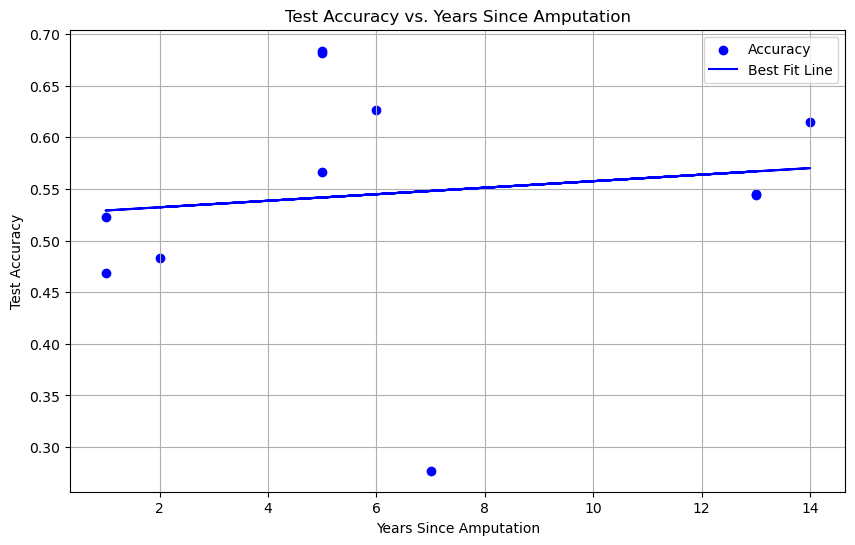

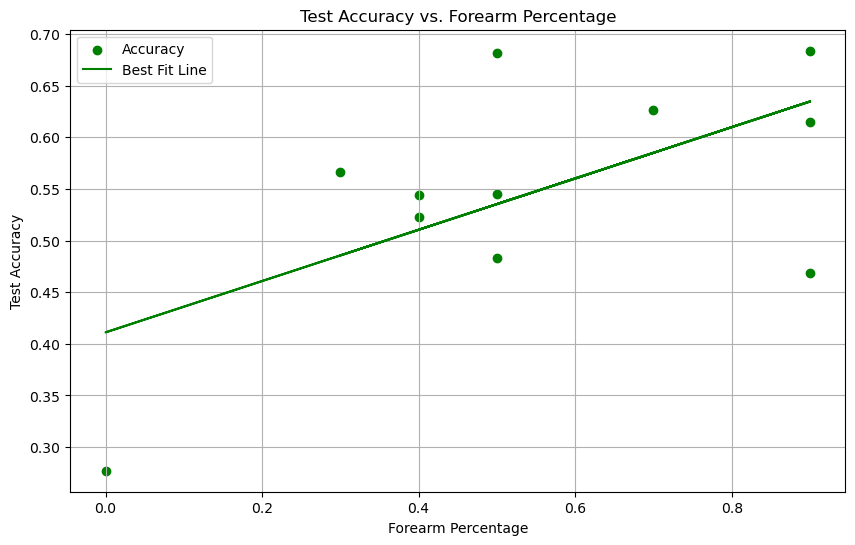

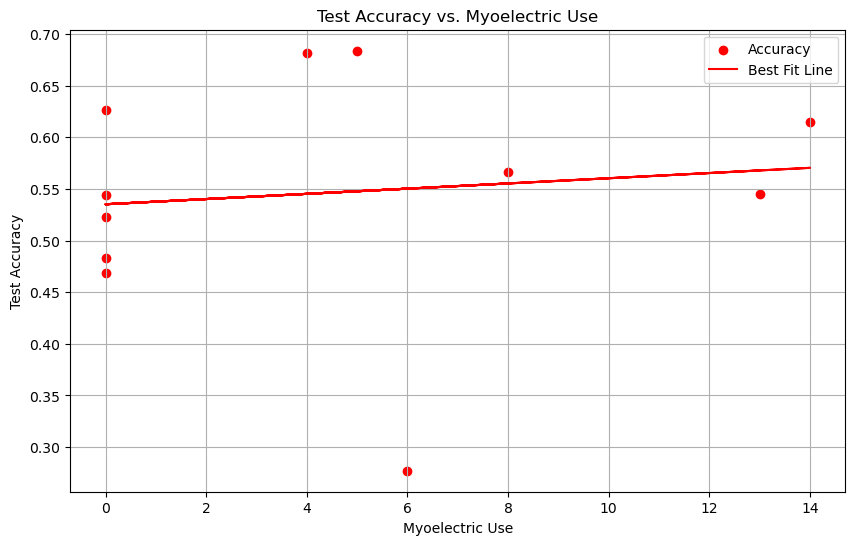

In [3]:
import scipy.stats as stats
import statsmodels.api as sm
# Statistical analysis function
# Convert results to DataFrame

def analyze_relationship(x, y, variable_name):
    # Pearson correlation
    r, p_value_corr = stats.pearsonr(x, y)
    
    # Linear Regression Analysis
    X = sm.add_constant(x)  # Add constant for intercept
    model = sm.OLS(y, X).fit()
    p_value_reg = model.pvalues[1]  # p-value for the predictor variable
    
    print(f"\nAnalysis for {variable_name}:")
    print(f"Pearson Correlation: r = {r:.4f}, p-value = {p_value_corr:.4f}")
    print(f"Linear Regression: Coefficient = {model.params[1]:.4f}, p-value = {p_value_reg:.4f}")
    
    if p_value_corr < 0.05:
        print(f"→ The correlation between {variable_name} and Accuracy is statistically significant (p < 0.05).")
    else:
        print(f"→ No significant correlation found (p >= 0.05).")
    
    if p_value_reg < 0.05:
        print(f"→ The regression model suggests a significant effect of {variable_name} on Accuracy (p < 0.05).")
    else:
        print(f"→ No significant effect found in regression (p >= 0.05).")

# Perform analysis
analyze_relationship(results_df['YearsSinceAmputation'], results_df['TestAccuracy'], "Years Since Amputation")
analyze_relationship(results_df['ForearmPercentage'], results_df['TestAccuracy'], "Forearm Percentage")
analyze_relationship(results_df['MyoelectricUse'], results_df['TestAccuracy'], "Myoelectric Use")

# 2D Scatter Plots with Regression Lines
plt.figure(figsize=(10, 6))
plt.scatter(results_df['YearsSinceAmputation'], results_df['TestAccuracy'], c='blue', label='Accuracy')
coeffs = np.polyfit(results_df['YearsSinceAmputation'], results_df['TestAccuracy'], deg=1)
plt.plot(results_df['YearsSinceAmputation'], np.polyval(coeffs, results_df['YearsSinceAmputation']), color='blue', label='Best Fit Line')
plt.xlabel('Years Since Amputation')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Years Since Amputation')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(results_df['ForearmPercentage'], results_df['TestAccuracy'], c='green', label='Accuracy')
coeffs = np.polyfit(results_df['ForearmPercentage'], results_df['TestAccuracy'], deg=1)
plt.plot(results_df['ForearmPercentage'], np.polyval(coeffs, results_df['ForearmPercentage']), color='green', label='Best Fit Line')
plt.xlabel('Forearm Percentage')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Forearm Percentage')
plt.legend()
plt.grid()
plt.show()

# 2D Scatter Plots with Regression Lines
plt.figure(figsize=(10, 6))
plt.scatter(results_df['MyoelectricUse'], results_df['TestAccuracy'], c='red', label='Accuracy')
coeffs = np.polyfit(results_df['MyoelectricUse'], results_df['TestAccuracy'], deg=1)
plt.plot(results_df['MyoelectricUse'], np.polyval(coeffs, results_df['MyoelectricUse']), color='red', label='Best Fit Line')
plt.xlabel('Myoelectric Use')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Myoelectric Use')
plt.legend()
plt.grid()
plt.show()



In [4]:
# 3D Surface Plot for Accuracy vs Years Since Amputation & Forearm Percentage
x = results_df['ForearmPercentage']
y = results_df['YearsSinceAmputation']
z = results_df['TestAccuracy']

# Create a grid
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((x, y), z, (xi, yi), method='linear')

fig = go.Figure(data=[go.Surface(
    x=xi, y=yi, z=zi, colorscale='Viridis',
    contours=dict(z=dict(show=True, usecolormap=True, project_z=True))
)])

# Labels
fig.update_layout(
    title='RF: Test Accuracy vs. Years Since Amputation and Forearm Percentage',
    scene=dict(
        xaxis_title='Forearm Percentage',
        yaxis_title='Years Since Amputation',
        zaxis_title='Test Accuracy',
    ),
    width=800,
    height=700
)

fig.show()